In [102]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import gymnasium as gym
import os

from blackjack import ControlType, BlackJackAgent
from visualize import reward_plot, training_plot, create_grids, create_plots


In [103]:
full_path = os.path.abspath("q_value")

In [104]:
env = gym.make("Blackjack-v1", sab=True, natural=False)

env.observation_space.seed(20)
np.random.seed(20)

In [105]:
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2) 
final_epsilon = 0.001

# control_type = ControlType.DOUBLE_Q_LEARNING
# control_type = ControlType.Q_LEARNING
# control_type = ControlType.MONTE_CARLO
control_type = ControlType.TEMPORAL_DIFFERENCE

update = True

if control_type == ControlType.DOUBLE_Q_LEARNING:
    q_value_file = "double_q_learning.json"
elif control_type == ControlType.Q_LEARNING:
    q_value_file = "q_learning.json"
elif control_type == ControlType.MONTE_CARLO:
    q_value_file = "monte_carlo.json"
elif control_type == ControlType.TEMPORAL_DIFFERENCE:
    q_value_file = "temporal_difference.json"

agent = BlackJackAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=1.0
)

In [106]:
agent.load_model(full_path, q_value_file)

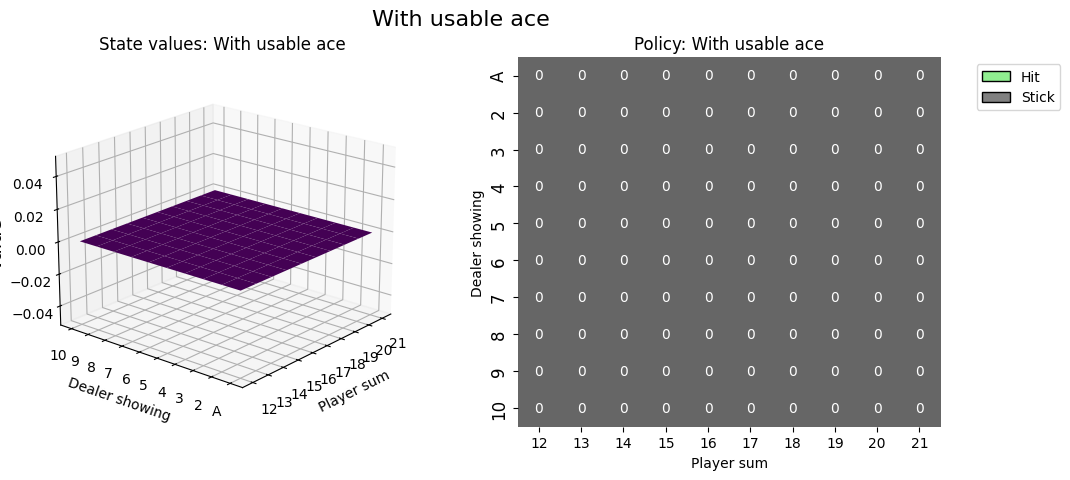

In [107]:
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

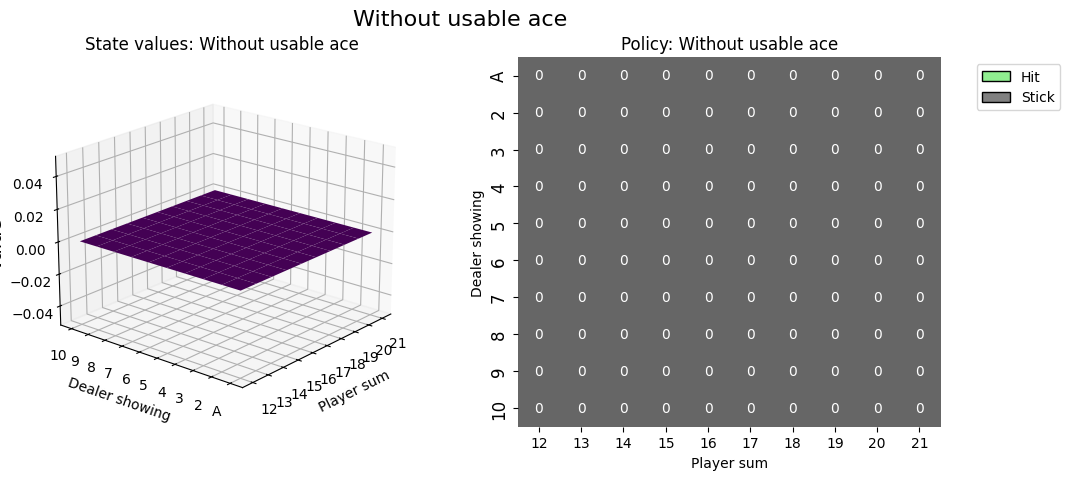

In [108]:
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [109]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    if control_type == ControlType.TEMPORAL_DIFFERENCE:
        action = agent.get_action(obs)

    # play one episode
    while not done:
        if control_type == ControlType.DOUBLE_Q_LEARNING:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            if update:
                agent.update(
                    obs=obs,
                    action=action,
                    reward=reward,
                    next_obs=next_obs,
                    terminated=terminated
                )
        elif control_type == ControlType.Q_LEARNING:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            if update:
                agent.update(
                    obs=obs,
                    action=action,
                    reward=reward,
                    next_obs=next_obs,
                    terminated=terminated
                )
        elif control_type == ControlType.MONTE_CARLO:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            agent.update(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )
        elif control_type == ControlType.TEMPORAL_DIFFERENCE:
            next_obs, reward, terminated, truncated, info = env.step(action)
            next_action = agent.get_action(next_obs)
            if update:
                agent.update(
                    obs=obs,
                    action=action,
                    reward=reward,
                    next_obs=next_obs,
                    next_action=next_action,
                    terminated=terminated
                )
            action = next_action

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:16<00:00, 5936.84it/s]


In [110]:
if start_epsilon != final_epsilon:
    agent.save_model(full_path, q_value_file)

In [111]:
type(env.return_queue)
print(len(np.array(env.return_queue).shape))

2


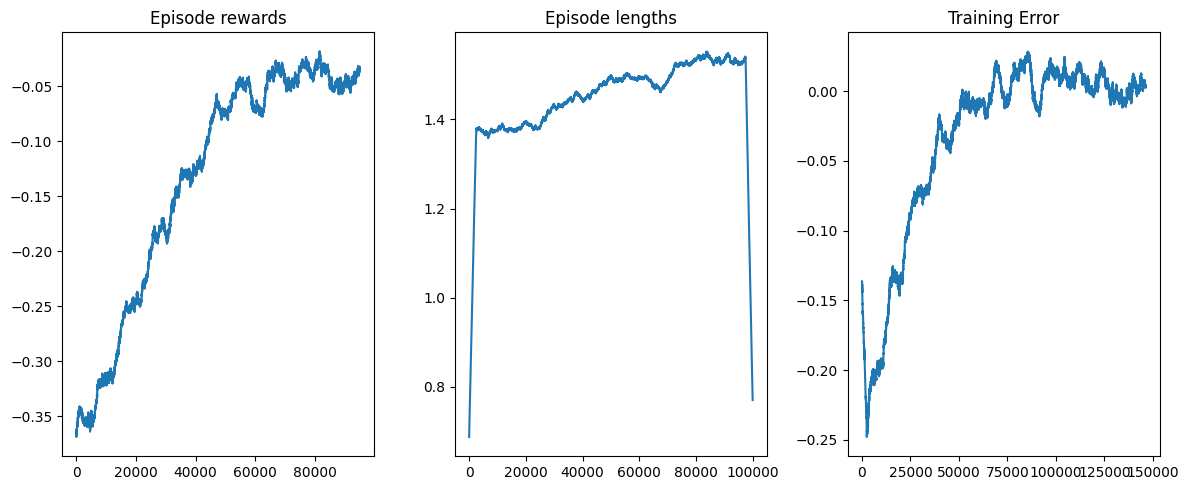

In [112]:
# rolling_length = 5000
# fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
# axs[0].set_title("Episode rewards")
# # compute and assign a rolling average of the data to provide a smoother graph
# reward_moving_average = (
#     np.convolve(
#         np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
#     )
#     / rolling_length
# )
# axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
# axs[1].set_title("Episode lengths")
# length_moving_average = (
#     np.convolve(
#         np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
#     )
#     / rolling_length
# )
# axs[1].plot(range(len(length_moving_average)), length_moving_average)
# try:
#     axs[2].set_title("Training Error")
#     training_error_moving_average = (
#         np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
#         / rolling_length
#     )
#     axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
# except:
#     pass
# plt.tight_layout()
# plt.show()
training_plot(env.return_queue, env.length_queue, agent.training_error, 5000)

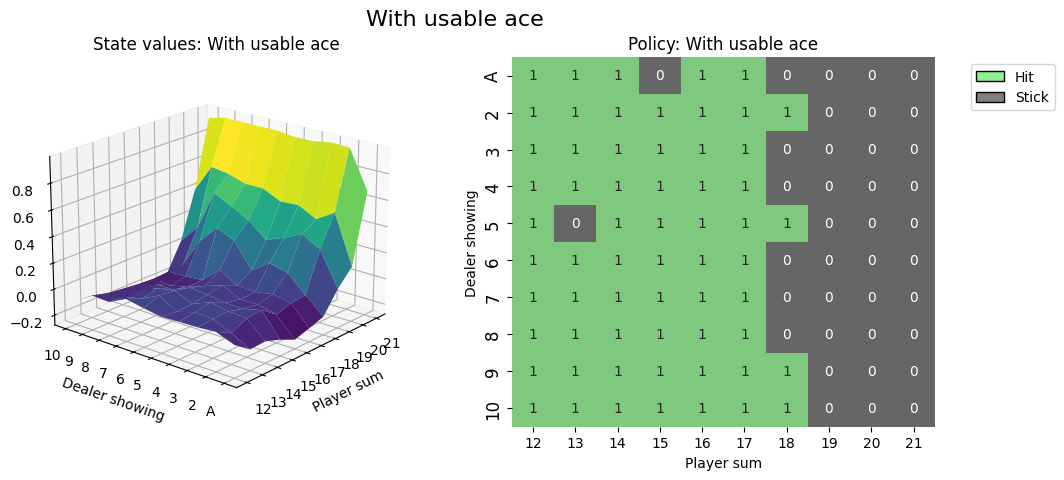

In [113]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

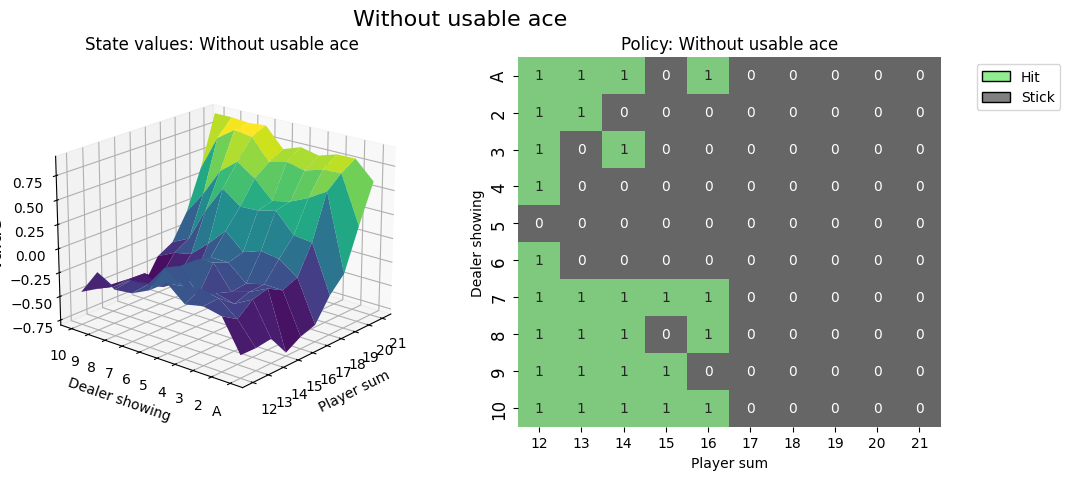

In [114]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent.q_values.items(), usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [115]:
np.array(env.return_queue).sum()

-13770.0

In [116]:
np.array(env.return_queue).sum() / n_episodes

-0.1377

====================== Reward Frequency ======================

Iteration[0:10000]     positive:0.2975 negative:0.655
Iteration[10000:20000]     positive:0.3255 negative:0.6198
Iteration[20000:30000]     positive:0.3576 negative:0.5817
Iteration[30000:40000]     positive:0.3848 negative:0.5426
Iteration[40000:50000]     positive:0.4067 negative:0.5132
Iteration[50000:60000]     positive:0.4246 negative:0.4856
Iteration[60000:70000]     positive:0.4315 negative:0.4864
Iteration[70000:80000]     positive:0.4367 negative:0.4754
Iteration[80000:90000]     positive:0.4329 negative:0.4744
Iteration[90000:100000]     positive:0.4331 negative:0.4738

====================== Reward Frequency ======================


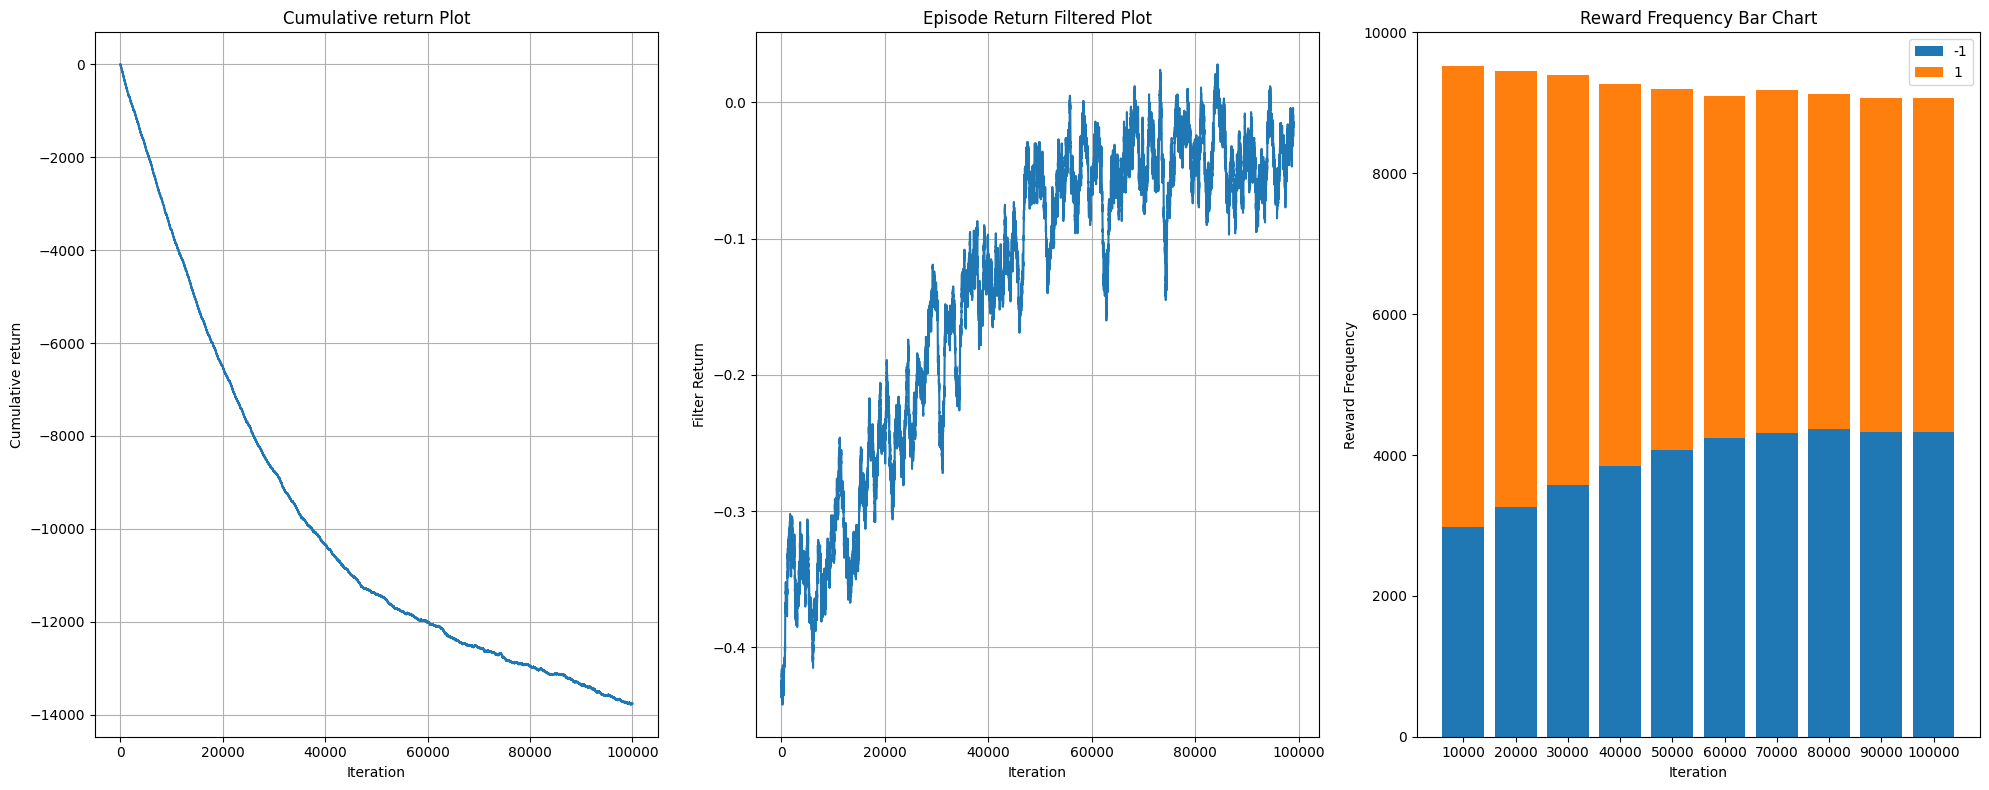

(array([-1.0000e+00, -2.0000e+00, -3.0000e+00, ..., -1.3770e+04,
        -1.3769e+04, -1.3770e+04]),
 array([-0.425, -0.425, -0.424, ..., -0.02 , -0.018, -0.018]))

In [117]:
reward_plot(n_episodes, 10, env.return_queue)